In our first example, we will implement a system dynamics model (SDM) analysis of a causal loop diagram (CLD) published as an example in the Education Corner article by Uleman et al (2024) doi: ...

In Kumu, the diagram looks as follows:


In [1]:
# Initialize the settings and load relevant packages and modules
setting_name = 'Sleep'
%run ../initialize.py {setting_name} {None} 

In [2]:
### Run simulations
df_sol_per_sample = []  # List for storing the solution dataframes

for num in tqdm(range(s.N)):  # Iterate over the number of samples
    if s.simulate_interventions: 
        df_sol = []
        for i, var in enumerate(s.intervention_variables):
            # Set the initial condition for the stocks to zero
            x0 = np.zeros(len(s.stocks_and_constants), order='F')  # By default no intervention on a stock or constant
            intervention_auxiliaries = []  # By default no intervention on an auxiliary

            if var in s.stocks_and_constants:
                x0[s.stocks_and_constants.index(var)] += 1  # Increase the (baseline) value of the stock/constant by 1
            else:  # var is an auxiliary
                intervention_auxiliaries = [var]  # Select the auxiliary to get an intercept of 1 in sample_model_parameters function

            params = sdm.sample_model_parameters(intervention_auxiliaries)  # Sample model parameters
            new_params = sdm.make_equations_auxiliary_independent() #params)  # Remove auxiliaries from the equations
            A, K, b = sdm.get_A_and_K_matrices() #new_params)  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
            df_sol_per_intervention = sdm.run_SDM(x0, A, K, b)
            df_sol += [df_sol_per_intervention]

    else:  # Just run regular simulations without interventions
        intervention_auxiliaries = []  # No interventions, so no auxiliary interventions
        params = sdm.sample_model_parameters(df_adj, interactions_matrix, None)  # Sample model parameters
        new_params = sdm.make_equations_auxiliary_independent() #params)  # Remove auxiliaries from the equations
        A, K, b = sdm.get_A_and_K_matrices() #new_params)  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries
        df_sol = [sdm.run_SDM(x0, A, K, b, s)]
    
    df_sol_per_sample += [df_sol]


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [ ]:
def f(time, x, params):
    """ Manual equations for the Sleep example for testing purposes.
    """
    # Auxiliaries
    p_a = (x[s.stocks_and_constants.index("Depressive_symptoms")] * params["Physical_activity"]["Depressive_symptoms"] + 
           params["Physical_activity"]["Intercept"])# Physical activity
    p_p = (x[s.stocks_and_constants.index("Depressive_symptoms")] * params["Proinflammatory_processes"]["Depressive_symptoms"] + 
           p_a * params["Proinflammatory_processes"]["Physical_activity"] +
           x[s.stocks_and_constants.index("Body_fat")] * params["Proinflammatory_processes"]["Body_fat"] +
           x[s.stocks_and_constants.index("Perceived_stress")] * params["Proinflammatory_processes"]["Perceived_stress"] +
           params["Proinflammatory_processes"]["Intercept"]
           ) # Proinflammatory processes
    s_p = (x[s.stocks_and_constants.index("Body_fat")] * params["Sleep_problems"]["Body_fat"] + 
           x[s.stocks_and_constants.index("Perceived_stress")] * params["Sleep_problems"]["Perceived_stress"] +
           p_p * params["Sleep_problems"]["Proinflammatory_processes"] + params["Sleep_problems"]["Intercept"]
           ) # Sleep problems
    
    # print("Auxiliaries: ", p_a, p_p, s_p)

    # Stocks, order: Depressive_symptoms, Childhood_adversity, Body_fat, Perceived_stress, Treatment
    d_s = (s_p * params["Depressive_symptoms"]["Sleep_problems"] + 
           x[s.stocks_and_constants.index("Childhood_adversity")] * params["Depressive_symptoms"]["Childhood_adversity"] +
           x[s.stocks_and_constants.index("Perceived_stress")] * params["Depressive_symptoms"]["Perceived_stress"] +
           x[s.stocks_and_constants.index("Treatment")] * params["Depressive_symptoms"]["Treatment"] + 
           p_p * params["Depressive_symptoms"]["Proinflammatory_processes"] + params["Depressive_symptoms"]["Intercept"]
           )  # Depressive symptoms
    c_a = 0  # Childhod adversity
    b_f = (s_p * p_a * params["Body_fat"]["Physical_activity * Sleep_problems"] +
           s_p * params["Body_fat"]["Sleep_problems"] + 
           p_a * params["Body_fat"]["Physical_activity"] + params["Body_fat"]["Intercept"]
           )  # Body fat
    p_s = (s_p * params["Perceived_stress"]["Sleep_problems"] + 
           x[s.stocks_and_constants.index("Depressive_symptoms")] * params["Perceived_stress"]["Depressive_symptoms"] +
           x[s.stocks_and_constants.index("Childhood_adversity")] * params["Perceived_stress"]["Childhood_adversity"] + 
           params["Perceived_stress"]["Intercept"]
           )  # Perceived stress'
    t_m = (x[s.stocks_and_constants.index("Depressive_symptoms")] * params["Treatment"]["Depressive_symptoms"] + 
           params["Treatment"]["Intercept"]) # Treatment

    return np.array([d_s, c_a, b_f, p_s, t_m])

#### Compare the results to straightforward implementation of equations
def test_with_sleep_depression_model():
    """ Test whether the vectorized equations are the same as the manually implemented equations.
    """
    params = sample_model_parameters(df_adj, interactions_matrix, s, intervention_auxiliaries)  # Sample model parameters
    new_params = make_equations_auxiliary_independent(params, s)  # Remove auxiliaries from the equations
    A, K, b = get_A_and_K_matrices(new_params, s)  # Get A and K matrices and intercept vector from the parameter dictionary without auxiliaries

    solution = solve_ivp(solve_sdm, t_span, x0, args=(A, K),
                            t_eval=t_eval, method=solver, rtol=1e-6, atol=1e-6)
    
    sol_test = solve_ivp(f, t_span, x0, args=(params,), 
                     t_eval=t_eval, method=solver, rtol=1e-6, atol=1e-6)
    assert np.allclose(sol_test, solution)

     # df_sol_test = pd.DataFrame(sol_test.y.T, columns=s.stocks_and_constants, index=t_eval)
       #assert ((df_sol_per_sample[-1][-1]-df_sol_test)**2).sum().sum() < 1e-15 # Check if the solutions are the same

# df_sol_alt = pd.DataFrame(solution.y.T, columns=s.stocks_and_constants, index=t_eval)
# df_sol_alt["Time"] = df_sol.index

# # Get auxiliary variables at each time step; these are not included in the solution
# df_sol_alt_with_aux = evaluate_auxiliaries(params_wo_stocks, df_sol_alt, t_eval)
# df_sol_alt_with_aux

# plt.plot(np.sqrt((df_sol_with_aux-df_sol_alt_with_aux)**2))
# plt.legend(df_sol_with_aux.columns)
# plt.ylabel("RMSE")
# plt.xlabel("Time")


In [3]:

def plot_simulated_interventions(df_pred, title, s, confidence_bounds=.95):
    """
    Plot the simulated interventions.

    Parameters:
    - df_pred: DataFrame containing the simulated data.
    - title: Title of the plot.
    - s: Object containing system information.

    Returns:
    - None (Displays the plot).
    """

    num_plots = len(s.intervention_variables)
    num_rows = int(np.ceil(num_plots / 3))

    fig, axs = plt.subplots(num_rows, 3, figsize=(12, 4 * num_rows))
    fig.suptitle(title)

    ax = axs.flatten()
    N = len(df_pred)

    for k, var in enumerate(s.intervention_variables):
       # if confidence_bounds != False:
        means_at_time_t = []
        lb_confs_at_time_t = []
        ub_confs_at_time_t = []

        for t in t_eval:
            samples_at_time_t = [df_sol_per_sample[n][k].loc[t, s.variable_of_interest] for n in range(N)]
            #[df_pred[i].loc[t, var] for i in range(N)]
            mean = np.mean(samples_at_time_t)
            standard_error = scipy.stats.sem(samples_at_time_t)
            h = standard_error * scipy.stats.t.ppf((1 + confidence_bounds) / 2., N-1)
            means_at_time_t.append(mean)
            lb_confs_at_time_t.append(mean-h)
            ub_confs_at_time_t.append(mean+h)

        ax[k].plot(t_eval, means_at_time_t, label="Mean")
        ax[k].fill_between(t_eval, lb_confs_at_time_t, ub_confs_at_time_t,
                            alpha=.3, label=str(int(confidence_bounds*100)) + "% CI") #Confidence interval")
        #else:
        #    for i, data_i, in enumerate(df_pred):
        #        ax[k].plot(data_i.Time, data_i[var], alpha=.3) 
        

        label = " ".join(s.variable_of_interest.split("_"))
        ax[k].set_ylabel(label)
        title = "Intervention on " + " ".join(var.split("_"))
        ax[k].set_title(title)

        if k >= num_plots - 3:  # Last row of plots
            ax[k].set_xlabel(s.time_unit)

        if k == 0:
            ax[k].legend()

    # Hide unused subplot space
    for b in range(num_rows * 3 - num_plots):
        ax[num_plots + b].axis('off')

    plt.tight_layout()
    plt.show()

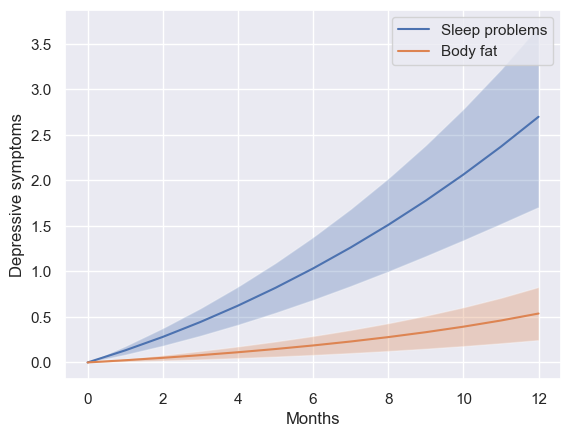

In [6]:
plt.figure()
confidence_bounds = .95
compare_int_vars = ["Sleep_problems", "Body_fat"]

for k, var in enumerate(compare_int_vars):
    means_at_time_t = []
    lb_confs_at_time_t = []
    ub_confs_at_time_t = []

    for t in t_eval:
        samples_at_time_t = [df_sol_per_sample[n][s.intervention_variables.index(var)].loc[t, s.variable_of_interest] for n in range(s.N)]
        mean = np.mean(samples_at_time_t)
        standard_error = scipy.stats.sem(samples_at_time_t)
        h = standard_error * scipy.stats.t.ppf((1 + confidence_bounds) / 2., s.N-1)
        means_at_time_t.append(mean)
        lb_confs_at_time_t.append(mean-h)
        ub_confs_at_time_t.append(mean+h)

    plt.plot(t_eval, means_at_time_t, label=" ".join(var.split("_")))
    plt.fill_between(t_eval, lb_confs_at_time_t, ub_confs_at_time_t,
                        alpha=.3) #, label=str(int(confidence_bounds*100)) + "% CI") #Confidence interval")
    plt.xlabel(s.time_unit)
    plt.ylabel(" ".join(s.variable_of_interest.split("_")))
    plt.legend()

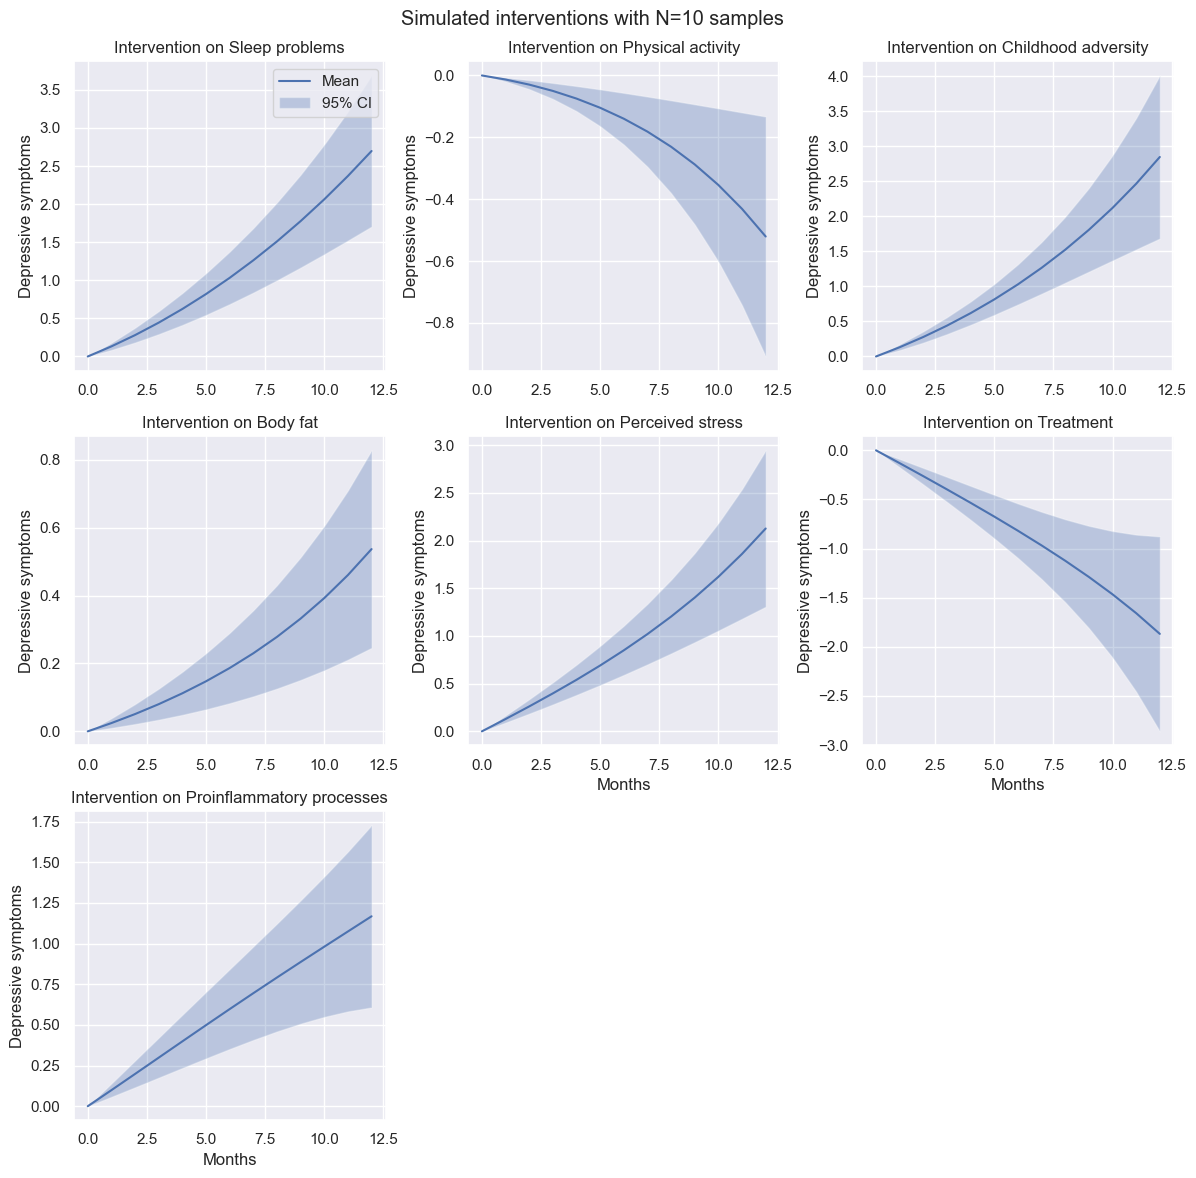

In [7]:
if s.simulate_interventions:
    plot_simulated_interventions(df_sol_per_sample, "Simulated interventions with N="+ str(s.N) + " samples", s, .95)
else:
    plot_simulated_data(df_sol_per_sample, "Simulation data with N="+ str(N) + " samples", s, .95)
    
# if s.save_results:
#     plt.savefig("Results/" + curr_time + '_' + setting_name + 
#             '/simulated_data_plots_per_individual' +
#             '.jpg',
#             format='jpg', dpi=300
#            )       

In [ ]:
def get_intervention_effects(df_sol_per_sample, s, print_effects=True):
    """
    """
    # Create a dictionary with intervention effects on the variable of interest
    intervention_effects = {i_v : [(df_sol_per_sample[n][i].loc[s.t_end, s.var_of_interest] -
                            df_sol_per_sample[n][i].loc[0, s.var_of_interest]) 
                            for n in range(N)] for i, i_v in enumerate(s.intervention_variables)}

    # Sort the dictionary by the mean intervention effect
    intervention_effects = dict(sorted(intervention_effects.items(),
                                    key=lambda item: np.median(item[1]), reverse=True))

    if print_effects:
        print("Intervention effect on var of interest", s.var_of_interest, "by:")
        for i, i_v in enumerate(intervention_effects.keys()):
            print("-", i_v, ":", round(np.mean(intervention_effects[i_v]), 2),
                "+- SD:", np.round(np.std(intervention_effects[i_v]), 2))
            
    return intervention_effects

intervention_effects = get_intervention_effects(df_sol_per_sample, s) 

In [ ]:
def plot_simulated_intervention_ranking(intervention_effects, s):
   """ Plot simulated intervention effects in a horizontal boxplot, ranked by median.
   """
   fig = plt.figure(figsize=(5, 8))  # 7,15
   ax = fig.add_subplot(111)
   df_SA = pd.DataFrame(intervention_effects)

   # Order by median
   df_SA = df_SA.reindex(columns=list(
                        df_SA.median().sort_values(ascending=False).index))
   df_SA = df_SA.rename(mapper=dict(
                        zip(s.intervention_variables,
                           [" ".join(var.split("_")) for var in s.intervention_variables ])), axis=1)

   sns.boxplot(data=df_SA, showfliers=False, whis=True, orient='h')
   plt.vlines(x=0, ymin=-0.5, ymax=len(s.intervention_variables) -
               0.6, colors='black', linestyles='dashed')
   plt.title("Effect on " + " ".join(s.var_of_interest.split("_")))
   plt.xlabel("Standardized effect after " + str(s.t_end) + " " + s.time_unit)
   plt.ylabel("")
   ax.invert_xaxis()

plot_simulated_intervention_ranking(intervention_effects, s)

In [ ]:
t_eval

In [ ]:
# Stability analysis
import numpy as np

def stability_analysis(A, b=[0]):
    # If b is provided, transform the system
    if np.all(b==0):  # The system is homogenous
        equilibrium = np.zeros(np.size(b))
    else:  # The system is not homogenous
        equilibrium = -np.matmul(np.linalg.inv(A), b)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(A)

    # Check stability
    stability = all(np.real(eigenvalue) < 0 for eigenvalue in eigenvalues)

    return stability, equilibrium, eigenvalues, eigenvectors

# Define A and b
A = np.array([[1, 2], [3, 4]])
b = np.array([0, 0]) # np.array([5, 6])

# Perform stability analysis
stability, equilibrium, eigenvalues, eigenvectors = stability_analysis(A, b)

print(f"The system is stability: {stability}")
print(f"At equilibrium point:  {equilibrium}")
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors: {eigenvectors}")


In [ ]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

# Define the system of ODEs
def system(x, t, A, K, b):
    return np.matmul(A, x) + np.matmul(Kx, x) + b

# Define the Jacobian of the system
##def jacobian(x, A, K):
    return A + 2 * K.dot(np.outer(x, np.eye(len(x))))

b = np.ones([3])
# Find the equilibrium point
x_star = fsolve(lambda x: system(x, 0, A, K, b), np.zeros([3]))

# Compute the Jacobian at the equilibrium point
J = A + 2 * np.matmul(K, x_star)
print("Jacobian matrix at the equilibrium point is:")

stability, notrelevant, eigenvalues, eigenvectors = stability_analysis(J, b)

print(f"The system is stability: {stability}")
print(f"At equilibrium point:  {x_star}")
print(f"Eigenvalues: {eigenvalues}")
print(f"Eigenvectors: {eigenvectors}")


In [ ]:
# try: analytic_sol = np.array([analytical_solution(t, x0, A, b) for t in t_eval]).T
# except: analytic_sol = np.array([analytical_solution_pinv(t, x0, A, b) for t in t_eval]).T

# #if s.solve_analytically: 
# start = time.time()
# for x in range(int(1e4)):
#     #try: 
#     #    A_inv = np.linalg.inv(A)  # Invert matrix A for the analytical solution
#     #except:
#     # Not needed because for invertible matrices the pseudo-inverse is the same as the inverse
#     A_inv = np.linalg.pinv(A)  # Pseudo-inverse for singular matrices
#     I = np.identity(A.shape[0])
#     analytic_sol = np.array([analytical_solution(t, x0, A, b, A_inv, I) for t in t_eval]).T

# #else:
# print("Time analytic: ", time.time()-start)

# start = time.time()
# for x in range(int(1e4)):
#     numerical_solution = solve_ivp(solve_sdm_linear, t_span, x0, args=(A, b),
#                                     t_eval=t_eval, jac=jac_linear,
#                                     method=solver, rtol=1e-8, atol=1e-8).y
# print("Time numerical: ", time.time()-start)

# # Difference numerical soluton and analytic solution with pseudoinverse
# assert np.allclose(analytic_sol, numerical_solution) #np.sum((analytic_sol-numerical_solution)**2) < 1e-8

# Numerical solution is faster with rtol/atol=1e-6
# The error is 1.0772777835270642e-10 with r/atol=1e-6
# This error becomes smaller when we increase the tolerance to 1e-10 
# Then the error is 2.9348171729108857e-18
# In that case also the analytic solution gets faster than numerical
# When making rtol even smaller the difference becomes smaller: 1.962871086279906e-29

In [ ]:
#### Implement Loops That Matter (Pseudoalgorithm provided in link below)
#### https://onlinelibrary.wiley.com/doi/full/10.1002/sdr.1658
### From the paper:
##"" The computation of the link and loop score metrics, nonetheless, does require that equations be computed multiple times per dt, 
# and this cannot bedone in standard software. For this article, we have modified an open sourceand publicly available simulation engine sd.js (Powers, 2019) 
# to simulate themodel and perform the link and loop score calculations. The pseudo code for this computation is shown below in Figure 1. 
# Figure 1 shows how we walk
# through all the variables in the model calculating the link scores for all links coming in to each variable. 
# First, for each variable (target), we check whether it is a stock or not. If the target is a stock,
# then we directly apply Eqn 2 to determine the link score from each flow (source) into the target. 
# If target is not a stock, we apply Eqn 1. When applying Eqn 1 for each source/target combination, 
# the first thing we do is determine what the value for target would have been if only source changed(tRespectSource). 
# To calculate tRespectSource, we call another subroutine which is capable of recalculating target using the current value of source and 
# the previous value of all other variables. Using tRespectSource, we determine the partial change in target with respect to source(del-taTRespectS). 
# The change in source and target are straightforward calculations using the current and previous values of target and source. Finally, we
# calculate the sign, making sure we do not produce a divide by zero, and then the link score, using the already calculated values. ""

# If A --> B, then A is a source and B is a target.

def aux_if_only_source_changed():
    # Determine what the value for target would have been if only source changed(tRespectSource). 
    # To calculate tRespectSource, we call another subroutine which is capable of recalculating target using the current value of source and 
    # the previous value of all other variables.
    
    ### Target is an auxiliary so does not depend on its previous value. 
    ### Thus, only needed to multiply the current value of the source with the model parameter in equation of target?
    return None  # curr_value_source * params[target][source]


## I THINK I CAN JUST RUN THROUGH THIS ROUTINE WITH A MATRIX OF PREDICTED VALUES

for target in variables:  # For all stocks and auxiliaries
    value = target.currentValue
    previousValue = target.previousValue
    
    if (target == stock):
        sumOfFlows = 0
        for source in target.sources:  # loop over the causes of the current variable
            if target.isInflow(source):  
                sumOfFlows += source.previousValue
            else  # is Outflow (this step is probably not needed for me)
                sumOfFlows -= source.previousValue
                
        for source in target.sources:
            if sumOfFlows == 0:
                LINKSCORE[source, target] = 0
            elif target.isInflow(source):  # Determine whether 'inflow' or outflow based on + or - of the model parameters
                LINKSCORE[source, target] = -abs(source.previousValue/sumOfFlows)
            else: 
                LINKSCORE[source, target] = abs(source.previousValue/sumOfFlows)
            
    elif value==previousValue:  # No change (probably true for constants; don't think I have to loop through those though)
        for source in target.sources:
            LINKSCORE[source, target] = 0

    else:  # Target is an auxiliary
        for source in target.sources:  # loop over the causes of the current variable
            tRespectSource = source.currentValue * params[target][source]  
            # Here we multiply the value of the source by the relevant model parameter (we dont have to account for interaction terms as these will be zero in this case).
            #aux_if_only_source_changed(target, source)  # <calc. target, use current source, prev. of rest>  
            deltaTRespectToS = tRespectSource - previousValue  # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode
            deltaSource = source.currentValue - source.previousValue
            deltaT = value - previousValue
            sign = 1
            
            if deltaSource != 0 and deltaTRespectS!= 0:
                sign = SIGN(deltaTRespectToS / deltaSource)

            LINKSCORE[source, target] = abs(deltaTRespectToS / deltaT) * sign   # Originally said "deltaTRespectS" but I think it's a mistake in the pseudocode

            
            
### Once we have the link scores we have to loop over all possible loops and assign them a Loop score
## First get all the loops based on adjacency matrix. Then we multiply all the link scores of the links in each loop.

Copilot wrote: Please note that you’ll need to define the calculate_target_using_current_source_previous_of_rest function according to your specific requirements. Also, model.variables, target.currentValue, target.previousValue, target.isStock, target.sources, target.isInflow(source), source.previousValue, source.currentSign, and source.previousSign are placeholders and you’ll need to replace them with your actual data or methods. This code is a direct translation of your pseudocode and might need adjustments based on your actual data structures and requirements.

In [ ]:
import numpy as np

# Initialize LINKSCORE as a dictionary
LINKSCORE = {}

# Function to calculate target using current source and previous of rest
def calculate_target_using_current_source_previous_of_rest(target, currentValue, previousValue, source):
    # Add your implementation here
    pass

# Iterating through each target in model variables
for target in model.variables:
    # Getting current and previous values of the target
    currentValue = target.currentValue
    previousValue = target.previousValue

    # Checking if the target is a stock
    if target.isStock:
        sumOfFlows = 0
        
        # Calculating sum of flows from all sources connected to this stock
        for source in target.sources:
            if target.isInflow(source):
                sumOfFlows += source.previousValue
            else:
                sumOfFlows -= source.previousValue
        
        # Updating link scores based on calculated sum of flows 
        for source in target.sources:
            if sumOfFlows == 0:
                LINKSCORE[source, target] = 0
            elif not isInflow(source):
                LINKSCORE[source, target] = -abs(source.previousValue / sumOfFlows)
            else:
                LINKSCORE[source, target] = abs(source.previousValue / sumOfFlows)
    
    # If value remains constant, setting link score to zero 
    elif currentValue == previousValue:  
        for source in target.sources:  
            LINKSCORE[source,target] = 0
    
    # If there's a change in value, updating link score accordingly 
    else:  
        for source in targets.sources:  
            
            tRespectSource = calculate_target_using_current_source_previous_of_rest(target,
                                                                                   currentValue,
                                                                                   previousValue,
                                                                                   source)
            
            deltaTRespectS = tRespectSource - previousValue
            
            deltaSource = source.currentSign - source.previousSign
            
            deltaT= currentValue - previousValue
            
            sign=1
            
             # Calculating sign based on deltas 
             if deltaSource != 0 and deltaTRespectS != 0:   
                 sign= np.sign(deltaTRespectToS/deltaSource) 
            
             LINKSCORE[source,target]= abs(deltaTRespects/deltaT)*sign;
